In [10]:
import sys
sys.path.append("../")

In [11]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
import matplotlib.pylab as plt
import pickle
from pathlib import Path
from PlayingCardsGenerator import CardsDataGenerator
from skimage.transform import resize

In [12]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [13]:
classes_names = ["2_clubs","2_diamonds","2_hearts","2_spades",\
               "3_clubs","3_diamonds","3_hearts","3_spades",\
               "4_clubs","4_diamonds","4_hearts","4_spades",\
               "5_clubs","5_diamonds","5_hearts","5_spades",\
               "6_clubs","6_diamonds","6_hearts","6_spades",\
               "7_clubs","7_diamonds","7_hearts","7_spades",\
               "8_clubs","8_diamonds","8_hearts","8_spades",\
               "9_clubs","9_diamonds","9_hearts","9_spades",\
               "10_clubs","10_diamonds","10_hearts","10_spades",\
               "ace_clubs","ace_diamonds","ace_hearts","ace_spades",\
               "jack_clubs","jack_diamonds","jack_hearts","jack_spades",\
               "king_clubs","king_diamonds","king_hearts","king_spades",\
               "queen_clubs","queen_diamonds","queen_hearts","queen_spades"]

In [14]:
gen_params = {"samplewise_center":True,\
              "samplewise_std_normalization":True}

In [15]:
generator = ImageDataGenerator(**gen_params, validation_split=0.15)

In [16]:
bs = 64 # batch size

In [17]:
path = Path("../dataset/")

In [18]:
img_height = 256
img_width = 256

In [19]:
train_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='training',
    interpolation="nearest",
    shuffle=True,
    seed=69,
    classes=classes_names) # set as training data

Found 26510 images belonging to 52 classes.


In [20]:
validation_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='validation',
    interpolation="nearest",
    shuffle=True,
    seed=69,
    classes=classes_names) # set as validation data

Found 4648 images belonging to 52 classes.


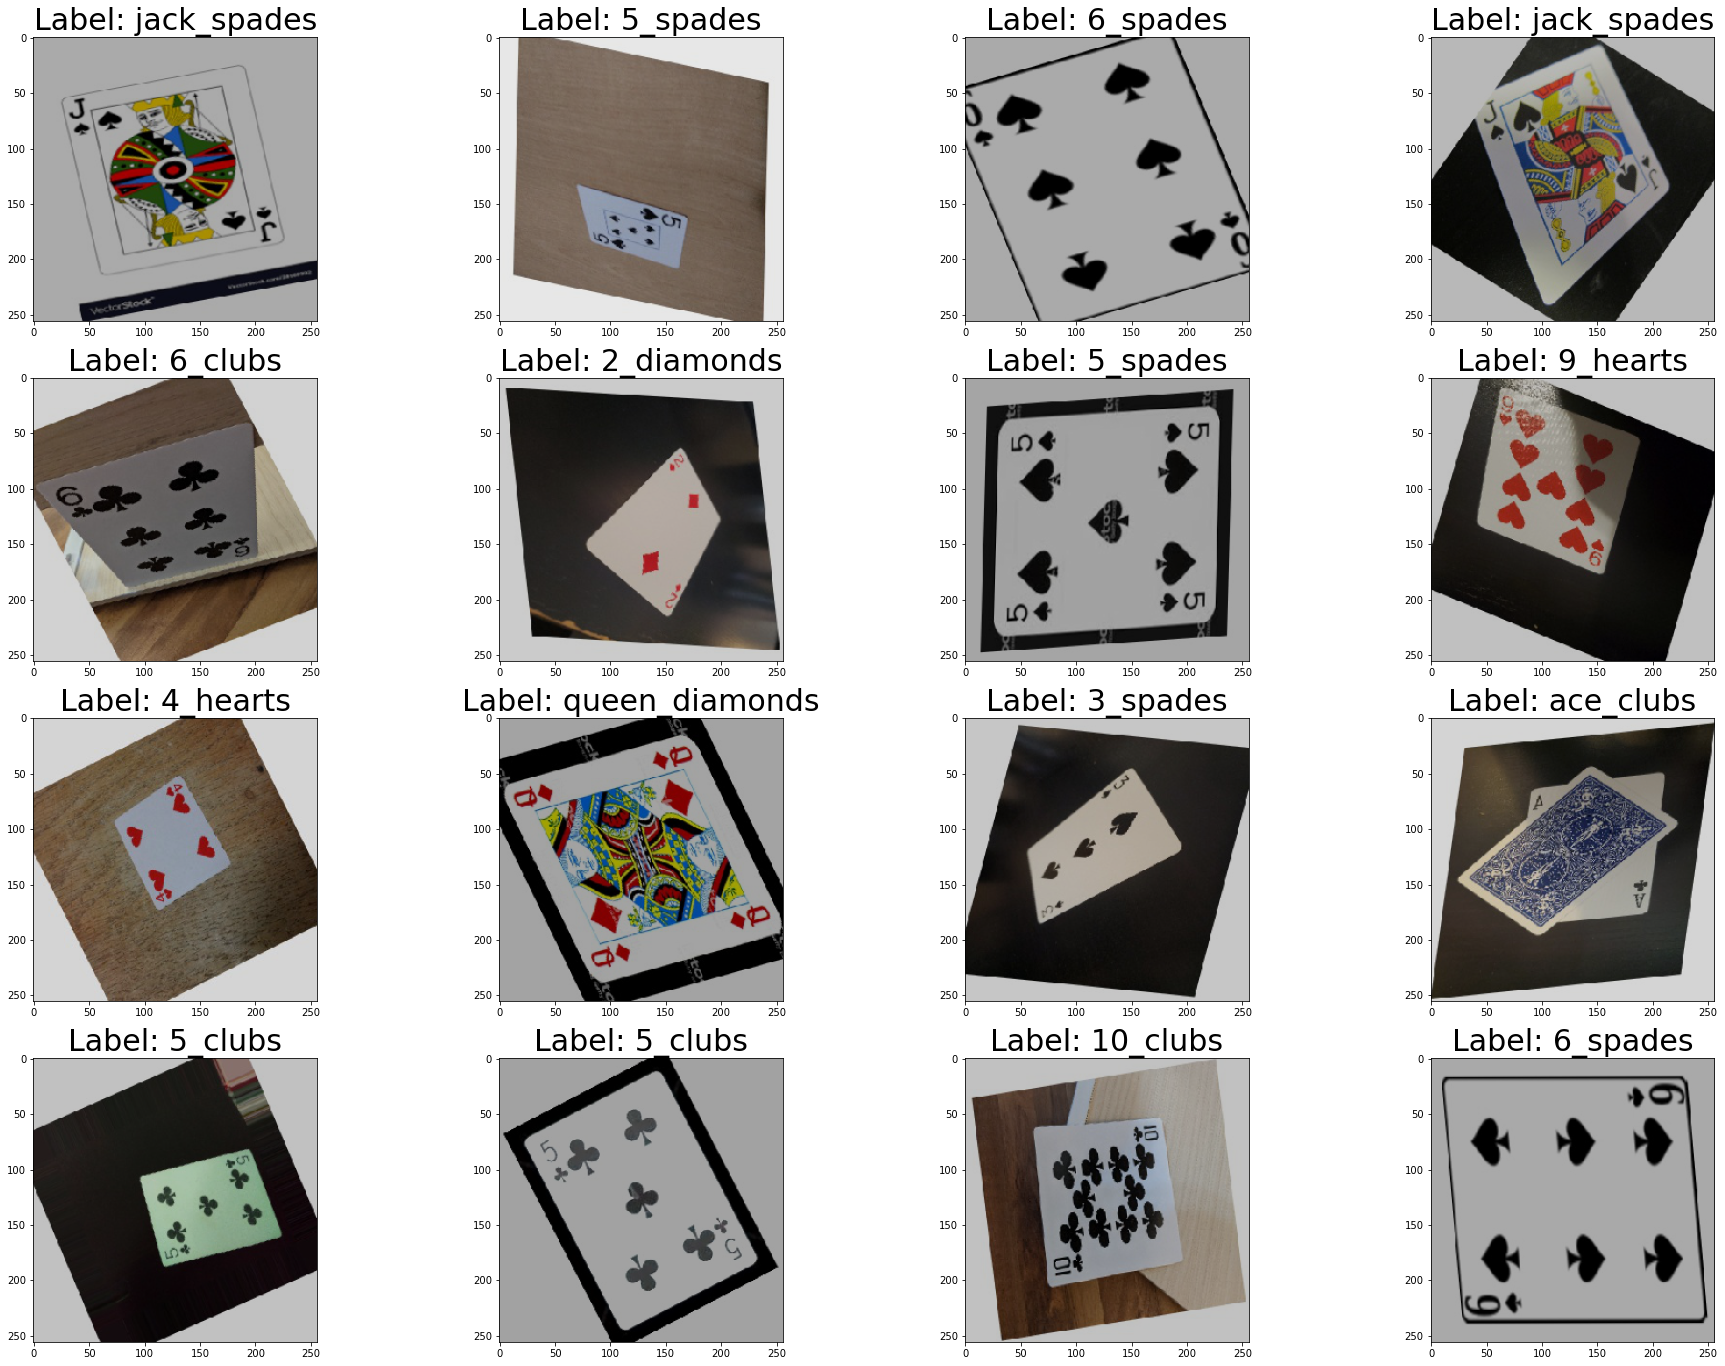

In [21]:
#Exploratory data analysis
Xbatch, Ybatch = train_generator.__getitem__(0)

plt.figure(figsize = (32,24))

labels = Ybatch

for ii in range(int(bs/4)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    label_idx = int(labels[ii].argmax())
    plt.title("Label: {}".format(classes_names[label_idx]),\
              fontsize=30)
plt.show()

In [22]:
ishape = (img_height, img_width, 3)
model_input = tf.keras.layers.Input(shape = ishape)

kernel_size = 3

l1 = tf.keras.layers.Conv2D(8, (kernel_size,kernel_size), activation='relu', padding="same")(model_input)
l2 = tf.keras.layers.Conv2D(8, (kernel_size,kernel_size), activation='relu', padding="same")(l1)
l3 = tf.keras.layers.MaxPooling2D(2, 2)(l2)
l4 = tf.keras.layers.Dropout(0.5)(l3)
l5 = tf.keras.layers.Conv2D(16, (kernel_size,kernel_size), activation='relu', padding="same")(l4)
l6 = tf.keras.layers.Conv2D(16, (kernel_size,kernel_size), activation='relu', padding="same")(l5)
l7 = tf.keras.layers.MaxPooling2D(2,2)(l6)
l8 = tf.keras.layers.Dropout(0.5)(l7)
l9 = tf.keras.layers.Conv2D(32, (kernel_size,kernel_size), activation='relu', padding="same")(l8)
l10 = tf.keras.layers.Conv2D(32, (kernel_size,kernel_size), activation='relu', padding="same")(l9)
l11 = tf.keras.layers.MaxPooling2D(2,2)(l10)
l12 = tf.keras.layers.Dropout(0.5)(l11)
l13 = tf.keras.layers.Conv2D(64, (kernel_size,kernel_size), activation='relu', padding="same")(l12)
l14 = tf.keras.layers.Conv2D(64, (kernel_size,kernel_size), activation='relu', padding="same")(l13)
l15 = tf.keras.layers.MaxPooling2D(2,2)(l14)
l16 = tf.keras.layers.Dropout(0.5)(l15)
l17 = tf.keras.layers.Conv2D(128, (kernel_size,kernel_size), activation='relu', padding="same")(l16)
l18 = tf.keras.layers.Conv2D(128, (kernel_size,kernel_size), activation='relu', padding="same")(l17)
l19 = tf.keras.layers.MaxPooling2D(2,2)(l18)
l20 = tf.keras.layers.Dropout(0.5)(l19)
l21 = tf.keras.layers.Conv2D(256, (kernel_size,kernel_size), activation='relu', padding="same")(l20)
l22 = tf.keras.layers.Conv2D(256, (kernel_size,kernel_size), activation='relu', padding="same")(l21)
l23 = tf.keras.layers.Dropout(0.5)(l22)

l24 = tf.keras.layers.Flatten()(l23)

# to make sure this is as close as possible to the two outputs model, keep the dense layer with 17 neurons
# (for comparison sake)
classifier = tf.keras.layers.Dense(17, activation = 'relu')(l24)

out = tf.keras.layers.Dense(len(classes_names) , activation = 'softmax')(classifier)

model = tf.keras.Model(inputs = model_input, outputs = out)

In [23]:
print("Model Summary:")
print(model.summary())

Model Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 8)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      1168      
                                              

In [24]:
def scheduler(epoch, lr):
    if epoch%25 == 0 and epoch!= 0:
        lr = lr/(1.5)
    return lr

filepath_name='model_{epoch:d}.h5'

monitor_it = tf.keras.callbacks.ModelCheckpoint(filepath = filepath_name , monitor='val_loss',\
                                             verbose=1,save_best_only=False,\
                                             save_weights_only=False,\
                                             mode='auto',\
                                             save_freq='epoch')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 40, min_delta=0.001)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [25]:
num_epochs = 1000
init_lr = 0.5e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = init_lr),\
              loss='categorical_crossentropy',\
              metrics=['accuracy'])

In [17]:
history_it = model.fit(train_generator, epochs=num_epochs, verbose = 1, \
                       workers=8, validation_data = (validation_generator),\
                       callbacks= [monitor_it, early_stop, lr_schedule], shuffle=True, initial_epoch=0)

Epoch 1/1000
415/415 [==============================] - ETA: 0s - loss: 3.9462 - accuracy: 0.0213
Epoch 1: saving model to model_1.h5
415/415 [==============================] - 60s 98ms/step - loss: 3.9462 - accuracy: 0.0213 - val_loss: 3.9429 - val_accuracy: 0.0284 - lr: 5.0000e-05
Epoch 2/1000
415/415 [==============================] - ETA: 0s - loss: 3.8938 - accuracy: 0.0344
Epoch 2: saving model to model_2.h5
415/415 [==============================] - 40s 95ms/step - loss: 3.8938 - accuracy: 0.0344 - val_loss: 3.8516 - val_accuracy: 0.0439 - lr: 5.0000e-05
Epoch 3/1000
415/415 [==============================] - ETA: 0s - loss: 3.7775 - accuracy: 0.0452
Epoch 3: saving model to model_3.h5
415/415 [==============================] - 40s 95ms/step - loss: 3.7775 - accuracy: 0.0452 - val_loss: 3.7349 - val_accuracy: 0.0387 - lr: 5.0000e-05
Epoch 4/1000
415/415 [==============================] - ETA: 0s - loss: 3.7018 - accuracy: 0.0510
Epoch 4: saving model to model_4.h5
415/415 [=====

Epoch 30/1000
415/415 [==============================] - ETA: 0s - loss: 2.1364 - accuracy: 0.3645
Epoch 30: saving model to model_30.h5
415/415 [==============================] - 40s 95ms/step - loss: 2.1364 - accuracy: 0.3645 - val_loss: 5.0081 - val_accuracy: 0.0706 - lr: 3.3333e-05
Epoch 31/1000
415/415 [==============================] - ETA: 0s - loss: 2.0958 - accuracy: 0.3773
Epoch 31: saving model to model_31.h5
415/415 [==============================] - 40s 95ms/step - loss: 2.0958 - accuracy: 0.3773 - val_loss: 4.7281 - val_accuracy: 0.0755 - lr: 3.3333e-05
Epoch 32/1000
415/415 [==============================] - ETA: 0s - loss: 2.0546 - accuracy: 0.3906
Epoch 32: saving model to model_32.h5
415/415 [==============================] - 40s 96ms/step - loss: 2.0546 - accuracy: 0.3906 - val_loss: 4.9378 - val_accuracy: 0.0755 - lr: 3.3333e-05
Epoch 33/1000
415/415 [==============================] - ETA: 0s - loss: 2.0222 - accuracy: 0.3931
Epoch 33: saving model to model_33.h5
41

Epoch 59/1000
415/415 [==============================] - ETA: 0s - loss: 1.3993 - accuracy: 0.5643
Epoch 59: saving model to model_59.h5
415/415 [==============================] - 40s 96ms/step - loss: 1.3993 - accuracy: 0.5643 - val_loss: 4.9312 - val_accuracy: 0.1213 - lr: 2.2222e-05
Epoch 60/1000
415/415 [==============================] - ETA: 0s - loss: 1.3835 - accuracy: 0.5637
Epoch 60: saving model to model_60.h5
415/415 [==============================] - 43s 102ms/step - loss: 1.3835 - accuracy: 0.5637 - val_loss: 5.2428 - val_accuracy: 0.1248 - lr: 2.2222e-05
Epoch 61/1000
415/415 [==============================] - ETA: 0s - loss: 1.3800 - accuracy: 0.5709
Epoch 61: saving model to model_61.h5
415/415 [==============================] - 42s 100ms/step - loss: 1.3800 - accuracy: 0.5709 - val_loss: 4.6809 - val_accuracy: 0.1355 - lr: 2.2222e-05
Epoch 62/1000
415/415 [==============================] - ETA: 0s - loss: 1.3658 - accuracy: 0.5742
Epoch 62: saving model to model_62.h5


Epoch 88/1000
415/415 [==============================] - ETA: 0s - loss: 1.1082 - accuracy: 0.6505
Epoch 88: saving model to model_88.h5
415/415 [==============================] - 44s 106ms/step - loss: 1.1082 - accuracy: 0.6505 - val_loss: 5.1508 - val_accuracy: 0.1519 - lr: 1.4815e-05
Epoch 89/1000
415/415 [==============================] - ETA: 0s - loss: 1.0948 - accuracy: 0.6496
Epoch 89: saving model to model_89.h5
415/415 [==============================] - 43s 101ms/step - loss: 1.0948 - accuracy: 0.6496 - val_loss: 5.1288 - val_accuracy: 0.1571 - lr: 1.4815e-05
Epoch 90/1000
415/415 [==============================] - ETA: 0s - loss: 1.0981 - accuracy: 0.6547
Epoch 90: saving model to model_90.h5
415/415 [==============================] - 40s 96ms/step - loss: 1.0981 - accuracy: 0.6547 - val_loss: 5.0380 - val_accuracy: 0.1568 - lr: 1.4815e-05
Epoch 91/1000
415/415 [==============================] - ETA: 0s - loss: 1.0913 - accuracy: 0.6541
Epoch 91: saving model to model_91.h5


415/415 [==============================] - ETA: 0s - loss: 0.8743 - accuracy: 0.7221
Epoch 144: saving model to model_144.h5
415/415 [==============================] - 40s 96ms/step - loss: 0.8743 - accuracy: 0.7221 - val_loss: 5.1241 - val_accuracy: 0.1844 - lr: 6.5844e-06
Epoch 145/1000
415/415 [==============================] - ETA: 0s - loss: 0.8743 - accuracy: 0.7178
Epoch 145: saving model to model_145.h5
415/415 [==============================] - 39s 92ms/step - loss: 0.8743 - accuracy: 0.7178 - val_loss: 5.1008 - val_accuracy: 0.1779 - lr: 6.5844e-06
Epoch 146/1000
415/415 [==============================] - ETA: 0s - loss: 0.8694 - accuracy: 0.7211
Epoch 146: saving model to model_146.h5
415/415 [==============================] - 45s 107ms/step - loss: 0.8694 - accuracy: 0.7211 - val_loss: 5.0760 - val_accuracy: 0.1846 - lr: 6.5844e-06
Epoch 147/1000
415/415 [==============================] - ETA: 0s - loss: 0.8663 - accuracy: 0.7216
Epoch 147: saving model to model_147.h5
415/

415/415 [==============================] - ETA: 0s - loss: 0.8022 - accuracy: 0.7429
Epoch 200: saving model to model_200.h5
415/415 [==============================] - 42s 100ms/step - loss: 0.8022 - accuracy: 0.7429 - val_loss: 5.3082 - val_accuracy: 0.1831 - lr: 2.9264e-06
Epoch 201/1000
415/415 [==============================] - ETA: 0s - loss: 0.7967 - accuracy: 0.7444
Epoch 201: saving model to model_201.h5
415/415 [==============================] - 40s 95ms/step - loss: 0.7967 - accuracy: 0.7444 - val_loss: 5.2505 - val_accuracy: 0.1850 - lr: 1.9509e-06
Epoch 202/1000
415/415 [==============================] - ETA: 0s - loss: 0.7946 - accuracy: 0.7410
Epoch 202: saving model to model_202.h5
415/415 [==============================] - 40s 95ms/step - loss: 0.7946 - accuracy: 0.7410 - val_loss: 5.2402 - val_accuracy: 0.1846 - lr: 1.9509e-06
Epoch 203/1000
415/415 [==============================] - ETA: 0s - loss: 0.8026 - accuracy: 0.7432
Epoch 203: saving model to model_203.h5
415/

415/415 [==============================] - ETA: 0s - loss: 0.7697 - accuracy: 0.7512
Epoch 256: saving model to model_256.h5
415/415 [==============================] - 48s 114ms/step - loss: 0.7697 - accuracy: 0.7512 - val_loss: 5.2679 - val_accuracy: 0.1887 - lr: 8.6708e-07
Epoch 257/1000
415/415 [==============================] - ETA: 0s - loss: 0.7738 - accuracy: 0.7524
Epoch 257: saving model to model_257.h5
415/415 [==============================] - 48s 114ms/step - loss: 0.7738 - accuracy: 0.7524 - val_loss: 5.2676 - val_accuracy: 0.1887 - lr: 8.6708e-07
Epoch 258/1000
415/415 [==============================] - ETA: 0s - loss: 0.7685 - accuracy: 0.7511
Epoch 258: saving model to model_258.h5
415/415 [==============================] - 48s 114ms/step - loss: 0.7685 - accuracy: 0.7511 - val_loss: 5.2141 - val_accuracy: 0.1891 - lr: 8.6708e-07
Epoch 259/1000
415/415 [==============================] - ETA: 0s - loss: 0.7618 - accuracy: 0.7535
Epoch 259: saving model to model_259.h5
41

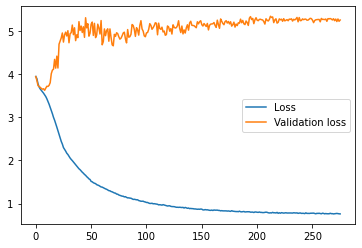

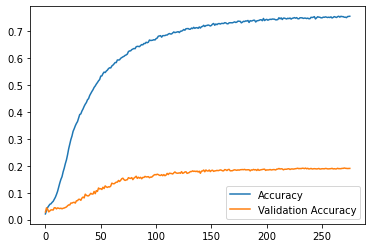

In [18]:
plt.figure()
plt.plot(history_it.history["loss"], label = "Loss")
plt.plot(history_it.history["val_loss"], label = "Validation loss")
plt.legend()

plt.figure()
plt.plot(history_it.history["accuracy"], label = "Accuracy")
plt.plot(history_it.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()

plt.show()

In [26]:
model = keras.models.load_model('best_model_single_output/best_model_single_output_25_acc.h5')

test_generator = ImageDataGenerator(**gen_params)

path_test = Path("../dataset_test/")

bs = 64

test_generator_flow = test_generator.flow_from_directory(
    directory = path_test,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    interpolation="nearest",
    shuffle=True,
    seed=21,
    classes=classes_names)

metrics = model.evaluate(test_generator_flow)

Found 7794 images belonging to 52 classes.
122/122 [==============================] - 254s 2s/step - loss: 4.8296 - accuracy: 0.2511
